PolitiFact.com publishes fact-checks on politician's statements.  I collected a dataset of Barack Obama's quotes for this assignment.

1. Import and pre-process the dataset as appropriate. (Reduce the task to a binary classification problem, drop any non-conforming records.) (5 pts.)

2. Develop an LSTM-based model with an embedding layer based on the training subset of data (use 70% of data for model training). Assess model performance (Recall, Precision, Accuracy, ROC AUC, PR AUC). (10 pts.)

3. Does the model have predictive value? Provide the rationale for your answer.(5 pts.)

4. Develop an LSTM-based model using GloVe pre-trained embedding (from SpaCy). Assess model performance (Recall, Precision, Accuracy, ROC AUC, PR AUC). (10 pts.)

5. Does the model have predictive value? Provide the rationale for your answer.(5 pts.)

Submit LastnameFirstname-A5.ipynb

In [30]:
import pandas as pd

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Flatten, LSTM, Conv1D, GlobalMaxPooling1D, Dropout, Activation
from keras.layers import Input, TextVectorization
from keras.callbacks import *
from keras.metrics import *
from keras.backend import clear_session
from keras.layers.embeddings import Embedding
from keras.initializers import Constant

import spacy

1. Import and pre-process the dataset as appropriate. (Reduce the task to a binary classification problem, drop any non-conforming records.)

In [31]:
pfacts = pd.read_csv('politifact-obama.csv')

pfacts.head()

,Score,Date,Quote
0,False,"July 22, 2021","""The cost of an automobile, it's kind of back ..."
1,False,"June 23, 2021","""The Second Amendment, from the day it was pas..."
2,False,"May 3, 2021",For vaccine rates among Americans 65 and older...
3,False,"March 25, 2021",“We’re sending back the vast majority of the f...
4,False,"February 16, 2021","""If we kept (the minimum wage) indexed to infl..."


In [32]:
pfacts.Score.value_counts()

Mostly True      211
Half True        211
True             148
False            107
Mostly False     101
Pants on Fire     15
Score              1
Name: Score, dtype: int64

In [33]:
pfacts.shape

(794, 3)

False score proportion:  0.2812105926860025


/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


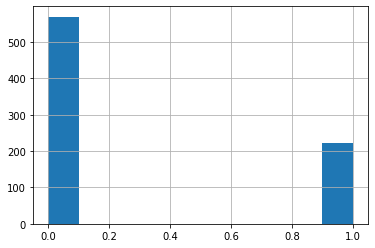

In [34]:
pfacts = pfacts.loc[pfacts['Score'] != 'Score']
pfacts.drop(['Date'], axis=1, inplace=True)
pfacts['sentiment'] = pfacts['Score'].replace({'Pants on Fire':1, 'Mostly False':1, 'False':1,
                                               'True':0, 'Mostly True':0, 'Half True':0})

pfacts.sentiment.hist()

print('False score proportion: ', pfacts.sentiment.mean())

In [35]:
pfacts.head()

,Score,Quote,sentiment
0,False,"""The cost of an automobile, it's kind of back ...",1
1,False,"""The Second Amendment, from the day it was pas...",1
2,False,For vaccine rates among Americans 65 and older...,1
3,False,“We’re sending back the vast majority of the f...,1
4,False,"""If we kept (the minimum wage) indexed to infl...",1


In [36]:
pfacts.shape

(793, 3)

In [37]:
from sklearn.model_selection import train_test_split

X = pfacts['Quote'].values.astype(str)
y = pfacts['sentiment']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=100)

2. Develop an LSTM-based model with an embedding layer based on the training subset of data (use 70% of data for model training). Assess model performance (Recall, Precision, Accuracy, ROC AUC, PR AUC).

In [38]:
tokenizer = Tokenizer()

tokenizer.fit_on_texts(list(X_train))

X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

X_train_seq = pad_sequences(X_train_seq, maxlen=100)
X_test_seq = pad_sequences(X_test_seq, maxlen=100)

In [39]:
size_of_vocabulary=len(tokenizer.word_index) + 1
print(size_of_vocabulary)

2301


In [40]:
METRICS = [
           TruePositives(name='tp'),
           FalsePositives(name='fp'),
           TrueNegatives(name='tn'),
           FalseNegatives(name='fn'),
           BinaryAccuracy(name='accuracy'),
           Precision(name='precision'),
           Recall(name='recall'),
           AUC(name='auc'),
           AUC(name='prc', curve='PR'),
]

In [41]:
clear_session()

model=Sequential()

model.add(Embedding(size_of_vocabulary,300,input_length=100,trainable=True))

model.add(LSTM(128,return_sequences=True,dropout=0.2))

model.add(GlobalMaxPooling1D())

model.add(Dense(64, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=METRICS)

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=3)
mc = ModelCheckpoint('best_model', monitor='val_loss', mode='min',
                     save_best_only=True, save_weights_only=False, verbose=1)

print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 100, 300)          690300    
                                                                 
 lstm (LSTM)                 (None, 100, 128)          219648    
                                                                 
 global_max_pooling1d (Globa  (None, 128)              0         
 lMaxPooling1D)                                                  
                                                                 
 dense (Dense)               (None, 64)                8256      
                                                                 
 dense_1 (Dense)             (None, 1)                 65        
                                                                 
Total params: 918,269
Trainable params: 918,269
Non-trainable params: 0
__________________________________________________

In [42]:
history = model.fit(np.array(X_train_seq),np.array(y_train), batch_size=128, epochs=10,
                    validation_data=(np.array(X_test_seq), np.array(y_test)), verbose=1,
                    callbacks=[es,mc])

Epoch 1/10
5/5 [==============================] - ETA: 0s - loss: 0.6652 - tp: 37.0000 - fp: 91.0000 - tn: 316.0000 - fn: 111.0000 - accuracy: 0.6360 - precision: 0.2891 - recall: 0.2500 - auc: 0.5299 - prc: 0.2872
Epoch 00001: val_loss improved from inf to 0.62898, saving model to best_model


INFO:tensorflow:Assets written to: best_model/assets


INFO:tensorflow:Assets written to: best_model/assets


5/5 [==============================] - 13s 2s/step - loss: 0.6652 - tp: 37.0000 - fp: 91.0000 - tn: 316.0000 - fn: 111.0000 - accuracy: 0.6360 - precision: 0.2891 - recall: 0.2500 - auc: 0.5299 - prc: 0.2872 - val_loss: 0.6290 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 163.0000 - val_fn: 75.0000 - val_accuracy: 0.6849 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.4898 - val_prc: 0.3048
Epoch 2/10
5/5 [==============================] - ETA: 0s - loss: 0.5930 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 407.0000 - fn: 148.0000 - accuracy: 0.7333 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.5127 - prc: 0.2771
Epoch 00002: val_loss did not improve from 0.62898
5/5 [==============================] - 3s 569ms/step - loss: 0.5930 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 407.0000 - fn: 148.0000 - accuracy: 0.7333 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.5127 - prc: 0.2771 - val_loss: 0.6506 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 163.000

INFO:tensorflow:Assets written to: best_model/assets


INFO:tensorflow:Assets written to: best_model/assets


5/5 [==============================] - 8s 2s/step - loss: 0.5845 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 407.0000 - fn: 148.0000 - accuracy: 0.7333 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.5070 - prc: 0.2774 - val_loss: 0.6233 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 163.0000 - val_fn: 75.0000 - val_accuracy: 0.6849 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.5146 - val_prc: 0.3421
Epoch 4/10
5/5 [==============================] - ETA: 0s - loss: 0.5756 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 407.0000 - fn: 148.0000 - accuracy: 0.7333 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.7838 - prc: 0.5989
Epoch 00004: val_loss improved from 0.62330 to 0.62271, saving model to best_model


INFO:tensorflow:Assets written to: best_model/assets


INFO:tensorflow:Assets written to: best_model/assets


5/5 [==============================] - 8s 2s/step - loss: 0.5756 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 407.0000 - fn: 148.0000 - accuracy: 0.7333 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.7838 - prc: 0.5989 - val_loss: 0.6227 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 163.0000 - val_fn: 75.0000 - val_accuracy: 0.6849 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.5596 - val_prc: 0.3653
Epoch 5/10
5/5 [==============================] - ETA: 0s - loss: 0.5687 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 407.0000 - fn: 148.0000 - accuracy: 0.7333 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.8795 - prc: 0.7385
Epoch 00005: val_loss did not improve from 0.62271
5/5 [==============================] - 3s 560ms/step - loss: 0.5687 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 407.0000 - fn: 148.0000 - accuracy: 0.7333 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.8795 - prc: 0.7385 - val_loss: 0.6242 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - va

INFO:tensorflow:Assets written to: best_model/assets


INFO:tensorflow:Assets written to: best_model/assets


5/5 [==============================] - 8s 2s/step - loss: 0.5373 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 407.0000 - fn: 148.0000 - accuracy: 0.7333 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.9321 - prc: 0.8282 - val_loss: 0.6204 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 163.0000 - val_fn: 75.0000 - val_accuracy: 0.6849 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.5847 - val_prc: 0.3880
Epoch 8/10
5/5 [==============================] - ETA: 0s - loss: 0.4919 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 407.0000 - fn: 148.0000 - accuracy: 0.7333 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.9697 - prc: 0.9262
Epoch 00008: val_loss did not improve from 0.62036
5/5 [==============================] - 3s 565ms/step - loss: 0.4919 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 407.0000 - fn: 148.0000 - accuracy: 0.7333 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.9697 - prc: 0.9262 - val_loss: 0.6473 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - va

In [43]:
model_results = model.evaluate(X_test_seq, y_test, batch_size=128, verbose=0)

for name, value in zip(model.metrics_names, model_results):
  print(name, ': ', value)

loss :  0.9238391518592834
tp :  10.0
fp :  9.0
tn :  154.0
fn :  65.0
accuracy :  0.6890756487846375
precision :  0.5263158082962036
recall :  0.13333334028720856
auc :  0.5917791724205017
prc :  0.39829379320144653


**Generally, this model's performance panned out very poorly.**

**The model's overall Accuracy of 68.9% is moderate which means both classes (False and True quotes) were correctly identified at a 68.9% rate.**

**However, this model's Recall is only 0.13 which means that it's identifying only 13% of quotes to be False which is the class of interest. Of those 13%, only 52% were actually False quotes (Precision).**

**The ROC AUC plots the distribution of True Positive cases vs. False Positive cases throughout different levels of thresholds. With a very low ROC AUC score of 59%, the interpretation is that the model does not perform well at distinguishing between these and is hovering around a 50/50 rate.**

**The PRC came in at only 0.39 which is very low and also contributes to the overall model's poor performance.**

3. Does the model have predictive value? Provide the rationale for your answer.

**I would conclude this model does not have predictive value and will not be worthy of being implemented practically. Given the nature of the goal given this dataset (identifying False quotes), this model did not prove to be of quality for this class of interest. With a very low Precision of 52%, a model for this dataset would ideally have a much greater success rate in False quote identification.**

4. Develop an LSTM-based model using GloVe pre-trained embedding (from SpaCy). Assess model performance (Recall, Precision, Accuracy, ROC AUC, PR AUC).

In [44]:
!python -m spacy download en_core_web_lg

     |████████████████████████████████| 827.9 MB 1.3 MB/s 
  Created wheel for en-core-web-lg: filename=en_core_web_lg-2.2.5-py3-none-any.whl size=829180942 sha256=e814ee8b93455bea243e527701dd75e6accd406a68a0a8e973f028a068e219a6
  Stored in directory: /tmp/pip-ephem-wheel-cache-8cauc1zc/wheels/11/95/ba/2c36cc368c0bd339b44a791c2c1881a1fb714b78c29a4cb8f5
Successfully built en-core-web-lg
✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_lg')


In [45]:
import en_core_web_lg

nlp = en_core_web_lg.load()
Vectorizer = TextVectorization()

In [46]:
Vectorizer.adapt(np.array(X_train).astype(str))
vocab = Vectorizer.get_vocabulary()

num_tokens = len(vocab)
embedding_dim = len(nlp('The').vector)
embedding_matrix = np.zeros((num_tokens, embedding_dim))
for i, word in enumerate(vocab):
  embedding_matrix[i] = nlp(str(word)).vector

Embedding_layer=Embedding(
    num_tokens,
    embedding_dim,
    embeddings_initializer=Constant(embedding_matrix),
    trainable=False)

In [47]:
clear_session()

model2 = Sequential()
model2.add(Input(shape=(1,), dtype=tf.string))

model2.add(Vectorizer)
model2.add(Embedding_layer)

model2.add(LSTM(128,return_sequences=True,dropout=0.2))

model2.add(GlobalMaxPooling1D())

model2.add(Dense(64,activation='relu'))
model2.add(Dense(1,activation='sigmoid'))

model2.compile(optimizer='adam', loss='binary_crossentropy', metrics=METRICS)

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=3)
mc = ModelCheckpoint('best_model2', monitor='val_loss', mode='min',
                     save_best_only=True, save_weights_only=False, verbose=1)

print(model2.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization (TextVec  (None, None)             0         
 torization)                                                     
                                                                 
 embedding_1 (Embedding)     (None, None, 300)         708300    
                                                                 
 lstm (LSTM)                 (None, None, 128)         219648    
                                                                 
 global_max_pooling1d (Globa  (None, 128)              0         
 lMaxPooling1D)                                                  
                                                                 
 dense (Dense)               (None, 64)                8256      
                                                                 
 dense_1 (Dense)             (None, 1)                 6

In [49]:
history2 = model2.fit(X_train, y_train, batch_size=128, epochs=10,
                      validation_data=(X_test, y_test), verbose=1, callbacks=[es,mc])

Epoch 1/10
5/5 [==============================] - ETA: 0s - loss: 0.6052 - tp: 10.0000 - fp: 9.0000 - tn: 561.0000 - fn: 213.0000 - accuracy: 0.7201 - precision: 0.5263 - recall: 0.0448 - auc: 0.5249 - prc: 0.3232
Epoch 00001: val_loss improved from inf to 0.63248, saving model to best_model2


INFO:tensorflow:Assets written to: best_model2/assets


INFO:tensorflow:Assets written to: best_model2/assets


5/5 [==============================] - 16s 3s/step - loss: 0.6052 - tp: 10.0000 - fp: 9.0000 - tn: 561.0000 - fn: 213.0000 - accuracy: 0.7201 - precision: 0.5263 - recall: 0.0448 - auc: 0.5249 - prc: 0.3232 - val_loss: 0.6325 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 163.0000 - val_fn: 75.0000 - val_accuracy: 0.6849 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.5858 - val_prc: 0.3864
Epoch 2/10
5/5 [==============================] - ETA: 0s - loss: 0.5761 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 407.0000 - fn: 148.0000 - accuracy: 0.7333 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.6100 - prc: 0.3807
Epoch 00002: val_loss improved from 0.63248 to 0.63083, saving model to best_model2


INFO:tensorflow:Assets written to: best_model2/assets


INFO:tensorflow:Assets written to: best_model2/assets


5/5 [==============================] - 11s 3s/step - loss: 0.5761 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 407.0000 - fn: 148.0000 - accuracy: 0.7333 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.6100 - prc: 0.3807 - val_loss: 0.6308 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 163.0000 - val_fn: 75.0000 - val_accuracy: 0.6849 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.5883 - val_prc: 0.3852
Epoch 3/10
5/5 [==============================] - ETA: 0s - loss: 0.5612 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 407.0000 - fn: 148.0000 - accuracy: 0.7333 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.6780 - prc: 0.4522
Epoch 00003: val_loss improved from 0.63083 to 0.61679, saving model to best_model2


INFO:tensorflow:Assets written to: best_model2/assets


INFO:tensorflow:Assets written to: best_model2/assets


5/5 [==============================] - 10s 2s/step - loss: 0.5612 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 407.0000 - fn: 148.0000 - accuracy: 0.7333 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.6780 - prc: 0.4522 - val_loss: 0.6168 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 163.0000 - val_fn: 75.0000 - val_accuracy: 0.6849 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.5758 - val_prc: 0.3875
Epoch 4/10
5/5 [==============================] - ETA: 0s - loss: 0.5592 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 407.0000 - fn: 148.0000 - accuracy: 0.7333 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.7124 - prc: 0.5017
Epoch 00004: val_loss improved from 0.61679 to 0.61478, saving model to best_model2


INFO:tensorflow:Assets written to: best_model2/assets


INFO:tensorflow:Assets written to: best_model2/assets


5/5 [==============================] - 11s 3s/step - loss: 0.5592 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 407.0000 - fn: 148.0000 - accuracy: 0.7333 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.7124 - prc: 0.5017 - val_loss: 0.6148 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 163.0000 - val_fn: 75.0000 - val_accuracy: 0.6849 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.5790 - val_prc: 0.3947
Epoch 5/10
5/5 [==============================] - ETA: 0s - loss: 0.5463 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 407.0000 - fn: 148.0000 - accuracy: 0.7333 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.7427 - prc: 0.5369
Epoch 00005: val_loss did not improve from 0.61478
5/5 [==============================] - 1s 201ms/step - loss: 0.5463 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 407.0000 - fn: 148.0000 - accuracy: 0.7333 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.7427 - prc: 0.5369 - val_loss: 0.6179 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - v

INFO:tensorflow:Assets written to: best_model2/assets


INFO:tensorflow:Assets written to: best_model2/assets


5/5 [==============================] - 10s 2s/step - loss: 0.5199 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 407.0000 - fn: 148.0000 - accuracy: 0.7333 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.7639 - prc: 0.5214 - val_loss: 0.6064 - val_tp: 1.0000 - val_fp: 1.0000 - val_tn: 162.0000 - val_fn: 74.0000 - val_accuracy: 0.6849 - val_precision: 0.5000 - val_recall: 0.0133 - val_auc: 0.6252 - val_prc: 0.4218
Epoch 8/10
5/5 [==============================] - ETA: 0s - loss: 0.4962 - tp: 5.0000 - fp: 1.0000 - tn: 406.0000 - fn: 143.0000 - accuracy: 0.7405 - precision: 0.8333 - recall: 0.0338 - auc: 0.7931 - prc: 0.5979
Epoch 00008: val_loss did not improve from 0.60635
5/5 [==============================] - 1s 203ms/step - loss: 0.4962 - tp: 5.0000 - fp: 1.0000 - tn: 406.0000 - fn: 143.0000 - accuracy: 0.7405 - precision: 0.8333 - recall: 0.0338 - auc: 0.7931 - prc: 0.5979 - val_loss: 0.6180 - val_tp: 7.0000 - val_fp: 6.0000 - val_tn: 157.0000 - val_fn: 68.0000 - val_accuracy: 0.6891

In [50]:
model2_results = model2.evaluate(X_test, y_test, batch_size=128, verbose=0)

for name, value in zip(model2.metrics_names, model2_results):
  print(name, ': ', value)

loss :  0.6432709097862244
tp :  25.0
fp :  32.0
tn :  131.0
fn :  50.0
accuracy :  0.6554622054100037
precision :  0.4385964870452881
recall :  0.3333333432674408
auc :  0.6140286326408386
prc :  0.3974123001098633


**Overall, this model's results are just about as poor as the first models'.**

**The second model's Accuracy is slightly worse than the first model at being able to be correct on any class prediction only 65.5% of the time.**

**Although this model does show a much higher Recall rate than the first model (33% vs 13%), This model's Precision is drastically worse than the first model (43.8% vs 52.6%). This means that while this model can identify 1/3 of quotes as being False (which is very low as it is), only about 44% of them are actually False.**

**This model has slightly higher ROC AUC score- 61%. This means that the model does not perform well at distinguishing between TP vs. FP cases throughout specific thresholds.**

**Finally, PRC is practically the same in both models at about 0.4**

5. Does the model have predictive value? Provide the rationale for your answer.

**This model does not have predictive value. While it does have a higher Recall than the first model, it is incorrect on False labeling more often than the first model (43.8% Precision). Additionally, its overall Accuracy is lower. Given the nature of our dataset, a model that has high Precision and a higher Accuracy rate would be necessary for our objective.**